# 4.Final Modeling

**Purpose:** Apply final trained models (LightGBM & XGBoost) to the test set, generate predictions, evaluate performance, and save results.  

Contents:
1. **Import Libraries**  
   Load all necessary Python packages for data manipulation, modeling, evaluation, and visualization.

2. **Load Test Data**  
   Load and preprocess the test dataset, ensuring feature alignment with the trained models.

3. **Define Features and Target**  
   Identify feature columns and target column (`value`) for prediction.

4. **Load Final Models**  
   Load LightGBM and XGBoost models saved from final training.

5. **Make Predictions**  
   Apply the loaded models to the test set to generate predictions.

6. **Evaluate Performance (Optional)**  
   If target values are available in test data, compute RMSE, MAE, and R² score.

7. **Save Predictions**  
   Save the prediction results in CSV (or any preferred format) for further use or submission.

8. **Visualize Predictions (Optional)**  
   Compare actual vs predicted values via plots for sanity check and reporting.


## 4.1 Import Libraries

In [1]:
# -------------------------------
# IMPORT LIBRARIES
# -------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import lightgbm as lgb
import xgboost as xgb
import pickle

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## 4.2 Load Dataset

In [2]:
# -------------------------------
# LOAD TEST DATA
# -------------------------------
# Load processed test set (after feature engineering)
# Note: This test set should already include all lag/rolling features
test_df = pd.read_csv("../data/modeling/test.csv", parse_dates=["timestamp"])

# Inspect
display(test_df.head())
print(test_df.info())

,series_id,timestamp,value,hour,dayofweek,day,month,is_weekend,lag_1,lag_4,lag_96,temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),mean_sea_level_pressure (Pa),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1)
0,Solar5,2020-11-01,23.73,0,6,1,11,1,23.01,17.11,9.66,14.44,9.33,3.05,102398.77,0.71,497.65,355.39,0.94
1,Solar0,2020-11-01,32.02,0,6,1,11,1,31.90,23.39,12.19,14.44,9.33,3.05,102398.77,0.71,497.65,355.39,0.94
2,Solar4,2020-11-01,5.01,0,6,1,11,1,5.13,3.62,1.86,14.44,9.33,3.05,102398.77,0.71,497.65,355.39,0.94
3,Solar1,2020-11-01,8.51,0,6,1,11,1,7.95,6.31,3.17,14.44,9.33,3.05,102398.77,0.71,497.65,355.39,0.94
4,Solar3,2020-11-01,7.52,0,6,1,11,1,7.69,5.45,2.96,14.44,9.33,3.05,102398.77,0.71,497.65,355.39,0.94


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22956 entries, 0 to 22955
Data columns (total 19 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   series_id                          22956 non-null  object        
 1   timestamp                          22956 non-null  datetime64[ns]
 2   value                              22956 non-null  float64       
 3   hour                               22956 non-null  int64         
 4   dayofweek                          22956 non-null  int64         
 5   day                                22956 non-null  int64         
 6   month                              22956 non-null  int64         
 7   is_weekend                         22956 non-null  int64         
 8   lag_1                              22956 non-null  float64       
 9   lag_4                              22956 non-null  float64       
 10  lag_96                            

## 4.3 Define Features & Target

In [3]:
# -------------------------------
# DEFINE FEATURES AND TARGET
# -------------------------------
# Features are all columns except 'series_id', 'timestamp', and 'value'
# Target is 'value' (if available for validation)

target_col = "value"
feature_cols = [col for col in test_df.columns if col not in ["timestamp", "value", "series_id"]]

X_test = test_df[feature_cols]

# If test labels are available for validation purposes
y_test = test_df.get("value")  # Will be None if not available

print(f"Number of features: {len(feature_cols)}")

Number of features: 16


## 4.4 Load Final Model

In [4]:
# -------------------------------
# LOAD FINAL MODELS
# -------------------------------

# --- LightGBM ---
lgb_model = lgb.Booster(model_file="../models/lgb_model.txt")  # Load core API booster

# --- XGBoost ---
xgb_model = xgb.Booster()
xgb_model.load_model("../models/xgb_model.json")

## 4.5 Predictions

In [5]:
# -------------------------------
# PREDICTION
# -------------------------------

# --- LightGBM prediction ---
lgb_pred = lgb_model.predict(X_test)
# Core API requires numpy array or dataframe

# --- XGBoost prediction ---
# Core API requires DMatrix
dtest = xgb.DMatrix(X_test)
xgb_pred = xgb_model.predict(dtest)

## 4.5 Evaluate Performance

In [6]:
# -------------------------------
# VALUATE PERFORMANCE (if target exists)
# -------------------------------
if y_test is not None:
    # LightGBM metrics
    lgb_rmse = np.sqrt(mean_squared_error(y_test, lgb_pred))
    lgb_mae = mean_absolute_error(y_test, lgb_pred)
    lgb_r2 = r2_score(y_test, lgb_pred)

    print("=== LightGBM Performance on Test ===")
    print(f"RMSE: {lgb_rmse:.4f}")
    print(f"MAE: {lgb_mae:.4f}")
    print(f"R² Score: {lgb_r2:.4f}\n")

    # XGBoost metrics
    xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
    xgb_mae = mean_absolute_error(y_test, xgb_pred)
    xgb_r2 = r2_score(y_test, xgb_pred)

    print("=== XGBoost Performance on Test ===")
    print(f"RMSE: {xgb_rmse:.4f}")
    print(f"MAE: {xgb_mae:.4f}")
    print(f"R² Score: {xgb_r2:.4f}\n")
else:
    print("Target not available in test set. Only predictions will be saved.")

=== LightGBM Performance on Test ===
RMSE: 18.3777
MAE: 4.3392
R² Score: 0.9833

=== XGBoost Performance on Test ===
RMSE: 16.9525
MAE: 3.3279
R² Score: 0.9858



## 4.6 Save Predictions

In [7]:
# -------------------------------
# Save Predictions
# -------------------------------
# Combine results into one DataFrame
pred_df = pd.DataFrame({
    "series_id": test_df["series_id"],
    "timestamp": test_df["timestamp"],
    "value_lgb": lgb_pred,
    "value_xgb": xgb_pred
})

# Save to CSV
pred_df.to_csv("../results/test_predictions.csv", index=False)
print("Predictions saved to '../results/test_predictions.csv'.")

Predictions saved to '../results/test_predictions.csv'.


## 4.7 Visualize Predictions

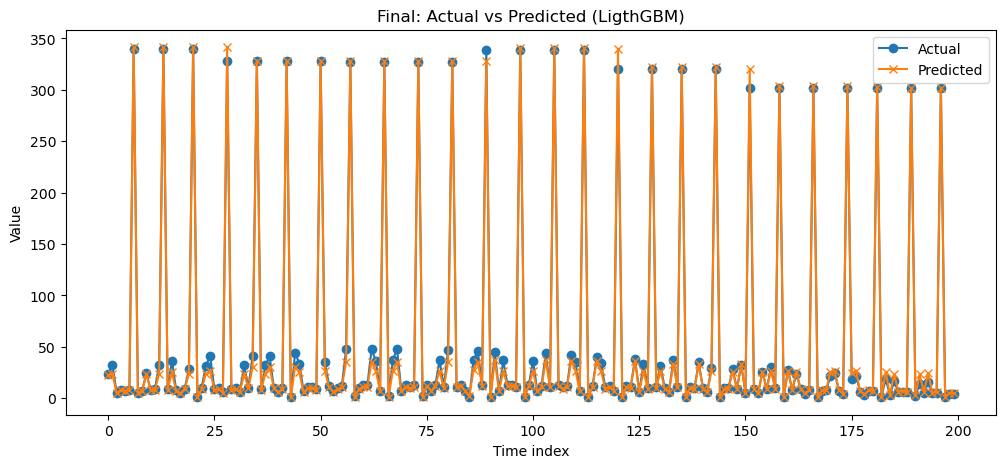

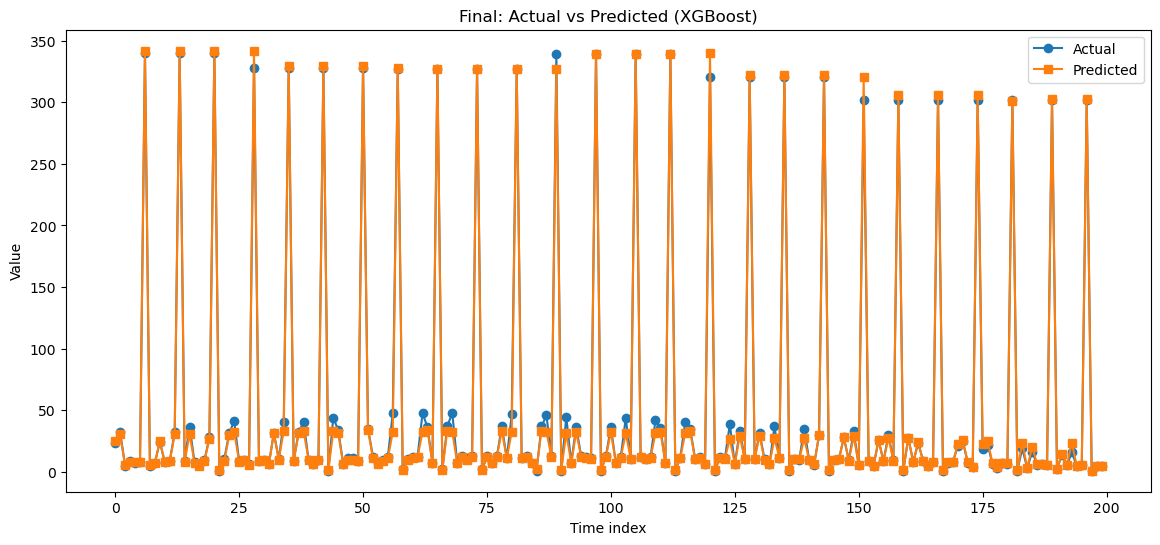

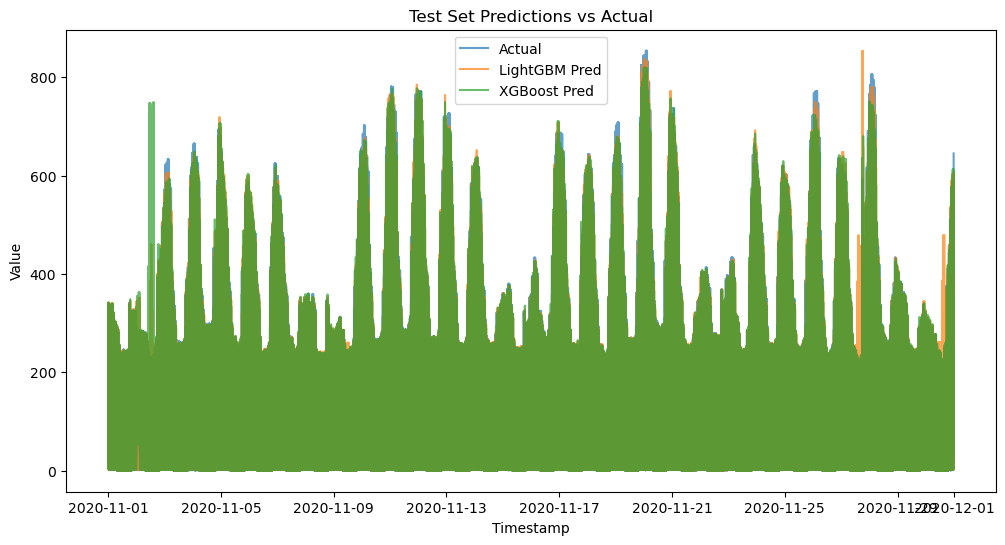

In [9]:
# -------------------------------
# VISUALIZE PREDICTIONS
# -------------------------------

# LightGBM
plt.figure(figsize=(12,5))
plt.plot(y_test.values[:200], label="Actual", marker='o')  # first 200 points
plt.plot(lgb_pred[:200], label="Predicted", marker='x')
plt.title("Final: Actual vs Predicted (LigthGBM)")
plt.xlabel("Time index")
plt.ylabel("Value")
plt.legend()
plt.savefig("../figures/final/lgb_actual_vs_prediction.png", dpi=300)
plt.show()

# XGBoost
plt.figure(figsize=(14,6))
plt.plot(y_test.values[:200], label="Actual", marker='o')
plt.plot(xgb_pred[:200], label="Predicted", marker='s')
plt.title("Final: Actual vs Predicted (XGBoost)")
plt.xlabel("Time index")
plt.ylabel("Value")
plt.legend()
plt.savefig("../figures/final/xgb_actual_vs_prediction.png", dpi=300)
plt.show()

# Compare actual vs predicted (only if target exists)
if y_test is not None:
    plt.figure(figsize=(12,6))
    plt.plot(test_df["timestamp"], y_test, label="Actual", alpha=0.7)
    plt.plot(test_df["timestamp"], lgb_pred, label="LightGBM Pred", alpha=0.7)
    plt.plot(test_df["timestamp"], xgb_pred, label="XGBoost Pred", alpha=0.7)
    plt.xlabel("Timestamp")
    plt.ylabel("Value")
    plt.title("Test Set Predictions vs Actual")
    plt.legend()
    plt.savefig("../figures/final/model_comparison.png", dpi=300)
    plt.show()

## 4.8 Key Insigth

LightGBM:
- **RMSE:** 18.3777  
- **MAE:** 4.3392  
- **R² Score:** 0.9833  

XGBoost:
- **RMSE:** 16.9525  
- **MAE:** 3.3279  
- **R² Score:** 0.9858  

Interpretation:
- Both models show **high accuracy** and explain over 98% of variance in the test set.  
- **XGBoost performs slightly better** in all metrics, especially MAE.  
- RMSE represents the **average magnitude of large errors**, while MAE represents the **average absolute error**.  
- In context: target values ~1300 → MAE of 3–4 and RMSE ~17 is **very small**, indicating the model predictions are very close to actual values.  

Deployment Recommendation:
- **Option 1:** Deploy only **XGBoost** (highest performance) for simplicity.  
- **Option 2:** Save both **LightGBM & XGBoost** for ensemble or comparative analysis.